# < TEST >

## 목차
## 1. Data Preparation
## 2. Set Parameter for test
## 3. test

### 1번 부분은 KETI에서 해당 코드가 잘 돌아가는지 확인하려고 만든 Data 가져오기 및 전처리 부분
### 이미 데이터를 준비했다면 2번으로 넘겨도 무방함

In [2]:
# setting
import sys, os
import pandas as pd
import torch

sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")
sys.path.append("../../../../")

from Clust.clust.ML.tool import meta as ml_meta
from Clust.clust.ML.tool import model as ml_model
from Clust.clust.ML.common import ML_api
from Clust.clust.ML.common import ML_pipeline, tool

from Clust.setting import influx_setting_KETI as ins
from Clust.clust.ingestion.influx import influx_client_v2 as influx_Client
from Clust.clust.ingestion.mongo.mongo_client import MongoClient

db_client = influx_Client.InfluxClient(ins.CLUSTDataServer2)
mongo_client = MongoClient(ins.CLUSTMetaInfo2)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.
cpu is available.


## Data Preparation (optional) 
### - Data가 준비되었다면 해당 부분을 스킵해도 무방함

### 1-1. Data Parameter Setting

In [19]:
model_purpose = 'regression'
data_name_X = 'regression_energy_cleanLevel4_testX'
feature_X_list = ['Press_mm_hg', 'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7',
   'RH_8', 'RH_9', 'RH_out', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7',
   'T8', 'T9', 'T_out', 'Tdewpoint', 'Visibility', 'Windspeed']
data_name_y = 'regression_energy_cleanLevel4_testy'
feature_y_list = ['value']
split_mode ="window_split"
data_y_flag = True # 이미 만들어진 Y 데이터를 활용함
scaler_param={
    'scaler_flag':'scale', #scale_param,
    'scale_method' :'minmax',
    'scaler_path' :'./scaler/'
}
transform_param={'split_mode': 'window_split',
 'data_clean_option': False,
 'nan_process_info': {'type': 'num',
  'ConsecutiveNanLimit': 10000,
  'totalNaNLimit': 100000},
 'max_nan_limit_ratio': 0.5,
 'future_step': None,
 'past_step': 144}
    
bucket_name = 'integration' 
data_clean_level = 4

model_name = 'regression_model_test'

### 1-2. Data Ingestion
#### 1-2-1. Select data name 

In [7]:
# Data Ingestion
ingestion_method = 'ms_all'
ingestion_param_X = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_X,
    'feature_list' : feature_X_list                              
}
ingestion_param_y = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_y,
    'feature_list' : feature_y_list                              
}

In [9]:
data_X, data_y = ML_pipeline.Xy_data_preparation(ingestion_param_X, data_y_flag, ingestion_param_y, ingestion_method, db_client)

{'bucket_name': 'integration', 'ms_name': 'regression_energy_cleanLevel4_testX', 'feature_list': ['Press_mm_hg', 'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'RH_out', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T_out', 'Tdewpoint', 'Visibility', 'Windspeed']}


In [15]:
X_scaler_file_path = './scaler/regression_energy_cleanLevel4_trainX/minmax/900878d7bba6f2a4017d1c3399909ea7/scaler.pkl'
y_scaler_file_path = './scaler/regression_energy_cleanLevel4_trainy/minmax/f69156750a210491ffd4a67b605bc88b/scaler.pkl'

In [16]:
test_X, scaler_X , test_y, scaler_y  = ML_pipeline.Xy_data_scaling_test(data_X, data_y, X_scaler_file_path, y_scaler_file_path, 'scale')

In [20]:
test_X_array, test_y_array = ML_pipeline.transform_data_by_split_mode(transform_param, test_X, test_y)

window_size: 144 nan_limit_num: 72
(6048, 24) (42, 144, 24)
(42, 1) (42, 1)


## 2. Set Parameter for test

In [21]:
model_method = 'LSTM_rg'
model_file_path = './Models/LSTM_rg/model/regression_model_test/model.pkl'

In [22]:
model_parameter = {'rnn_type': 'lstm',
 'input_size': 24,
 'hidden_size': 64,
 'num_layers': 2,
 'output_dim': 1,
 'dropout': 0.1,
 'bidirectional': True}

test_parameter = {
 'batch_size': 16,
 'device': 'cpu'}

## 3.Training

In [23]:
from Clust.clust.ML.regression.test import RegressionTest as RT
rt = RT()
rt.set_param(test_parameter)
rt.set_model(model_method, model_file_path, model_parameter)
rt.set_data(test_X_array, test_y_array)
preds, trues = rt.test()

features shape: torch.Size([42, 144, 24]) targets shape:  torch.Size([42, 1])

Start testing data



In [24]:
preds

array([0.45214742, 0.42449582, 0.39591122, 0.4268586 , 0.421584  ,
       0.39749128, 0.46048933, 0.46532404, 0.41883674, 0.44895104,
       0.431727  , 0.45729762, 0.4393112 , 0.53000563, 0.47244903,
       0.45280516, 0.38209456, 0.46500045, 0.44586635, 0.44806308,
       0.39295202, 0.4301445 , 0.46060455, 0.4090194 , 0.3224043 ,
       0.40175235, 0.4556175 , 0.49198264, 0.4605772 , 0.42560047,
       0.4956373 , 0.39563572], dtype=float32)

In [25]:
trues

array([0.5744986 , 0.73113656, 0.2903534 , 0.25501433, 0.33906394,
       0.27841452, 0.89684814, 0.2698185 , 0.40210125, 0.44030565,
       0.4598854 , 0.38634193, 0.29751667, 0.1905444 , 0.4890162 ,
       0.7445081 , 0.317574  , 0.47898754, 0.24498567, 0.43314227,
       0.23018146, 0.46704867, 0.3333333 , 0.2445081 , 0.4641834 ,
       0.20725884, 0.25549185, 0.59503335, 0.25549185, 0.5596943 ,
       0.74212027, 0.265043  ], dtype=float32)

## graph & metrix
### optional - 결과 확인용

In [26]:
print(test_X_array.shape, test_y_array.shape)
print(preds.shape, trues.shape)
target = feature_y_list[0]
scaler, feature_list = ML_pipeline.get_scaler_information_by_y_flag(data_y_flag, scaler_X, scaler_y, feature_X_list, feature_y_list)
df_result, result_metrics = ML_pipeline.get_final_metrics(preds, trues, scaler_param, scaler, feature_list, target)

(42, 144, 24) (42, 1)
(32,) (32,)
{'scaler_flag': 'scale', 'scale_method': 'minmax', 'scaler_path': './scaler/'}


       value  prediction
0   0.574499    0.452147
1   0.731137    0.424496
2   0.290353    0.395911
3   0.255014    0.426859
4   0.339064    0.421584
5   0.278415    0.397491
6   0.896848    0.460489
7   0.269819    0.465324
8   0.402101    0.418837
9   0.440306    0.448951
10  0.459885    0.431727
11  0.386342    0.457298
12  0.297517    0.439311
13  0.190544    0.530006
14  0.489016    0.472449
15  0.744508    0.452805
16  0.317574    0.382095
17  0.478988    0.465000
18  0.244986    0.445866
19  0.433142    0.448063
20  0.230181    0.392952
21  0.467049    0.430144
22  0.333333    0.460605
23  0.244508    0.409019
24  0.464183    0.322404
25  0.207259    0.401752
26  0.255492    0.455617
27  0.595033    0.491983
28  0.255492    0.460577
29  0.559694    0.425600
30  0.742120    0.495637
31  0.265043    0.395636
{'mae': 0.14360458, 'rmse': 0.1757732177594649, 'r2': 0.030879549636312897, 'mape': 42.303115129470825}


<Axes: >

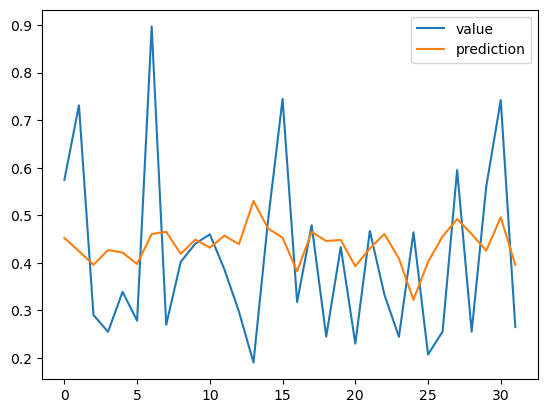

In [29]:
print(df_result)
print(result_metrics)
df_result.plot()